# Capstone Project: Police Call Outcome Prediction: Year 2017

This notebook explores and analyzes police call data in the city of San Jose, California, with the goal of predicting whether the outcome will be an arrest, a citation, or neither. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [112]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2017 from a CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [115]:
years = [2017]
year = "2017"

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 316174


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [117]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
199127,20170821222031PD,6824213,5/14/2021 12:00:00 AM,P172330818,3,8/21/2017 12:00:00 AM,8/21/2017 12:00:00 AM,21:22:21,23103,RECKLESS DRIVING,N,No report required; dispatch r,NaN,San Jose,CA,NaN,NaN,NaN
217657,20170911000922PD,6851696,5/14/2021 12:00:00 AM,P172530999,6,9/10/2017 12:00:00 AM,9/10/2017 12:00:00 AM,23:27:37,1195,VEHICLE STOP,N,No report required; dispatch r,ALUM ROCK AV & N WHITE RD,San Jose,CA,37.368713,-121.852678,Independence and Jackson
143156,20170620230622PD,6742076,5/14/2021 12:00:00 AM,P171710963,2,6/20/2017 12:00:00 AM,6/20/2017 12:00:00 AM,22:48:18,WELCK,WELFARE CHECK,N,No report required; dispatch r,[200]-[300] AVENIDA ESPANA,San Jose,CA,37.225134,-121.766979,Metcalf
156279,20170705063220PD,6761416,5/14/2021 12:00:00 AM,P171860204,2,7/5/2017 12:00:00 AM,7/5/2017 12:00:00 AM,06:24:51,1033S,"ALARM, SILENT",CAN,Canceled,[900]-[1000] S SUNSET AV,San Jose,CA,37.345451,-121.839840,Poco
315456,20171231020803PS,6998981,5/14/2021 12:00:00 AM,P173650087,6,12/31/2017 12:00:00 AM,12/31/2017 12:00:00 AM,01:26:16,1195,VEHICLE STOP,N,No report required; dispatch r,ALVIN AV & BURDETTE DR,San Jose,CA,37.320170,-121.826891,West Evergreen


In [120]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316174 entries, 0 to 316173
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              316174 non-null  object 
 1   EID               316174 non-null  int64  
 2   START_DATE        316174 non-null  object 
 3   CALL_NUMBER       316174 non-null  object 
 4   PRIORITY          316174 non-null  int64  
 5   REPORT_DATE       316174 non-null  object 
 6   OFFENSE_DATE      316174 non-null  object 
 7   OFFENSE_TIME      316174 non-null  object 
 8   CALLTYPE_CODE     316174 non-null  object 
 9   CALL_TYPE         316127 non-null  object 
 10  FINAL_DISPO_CODE  316174 non-null  object 
 11  FINAL_DISPO       316174 non-null  object 
 12  ADDRESS           305672 non-null  object 
 13  CITY              316174 non-null  object 
 14  STATE             316174 non-null  object 
 15  LATITUDE          284108 non-null  float64
 16  LONGITUDE         28

In [122]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.161740e+05,316174.000000,284108.000000,284108.000000
mean,6.763769e+06,3.200130,37.319867,-121.871048
std,1.360640e+05,1.333373,0.043069,0.048089
min,6.526536e+06,1.000000,37.155151,-122.035696
25%,6.646298e+06,2.000000,37.294827,-121.902172
50%,6.764162e+06,3.000000,37.323313,-121.869186
75%,6.880947e+06,4.000000,37.348205,-121.837718
max,7.000037e+06,6.000000,37.534539,-121.684849


In [124]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,316174,316174,316174,316174,316174,316174,316174,316127,316174,316174,305672,316174,316174,282657
unique,313958,1,306282,365,365,81206,220,213,22,18,31333,1,1,295
top,20171207103853PS,5/14/2021 12:00:00 AM,P172681035,7/4/2017 12:00:00 AM,7/4/2017 12:00:00 AM,22:35:42,415,DISTURBANCE,N,No report required; dispatch r,[2100]-[2200] MONTEREY RD,San Jose,CA,Spartan Keyes and Wool Creek
freq,4,316174,6,1187,1187,18,31040,31036,125971,125971,1223,316174,316174,8435


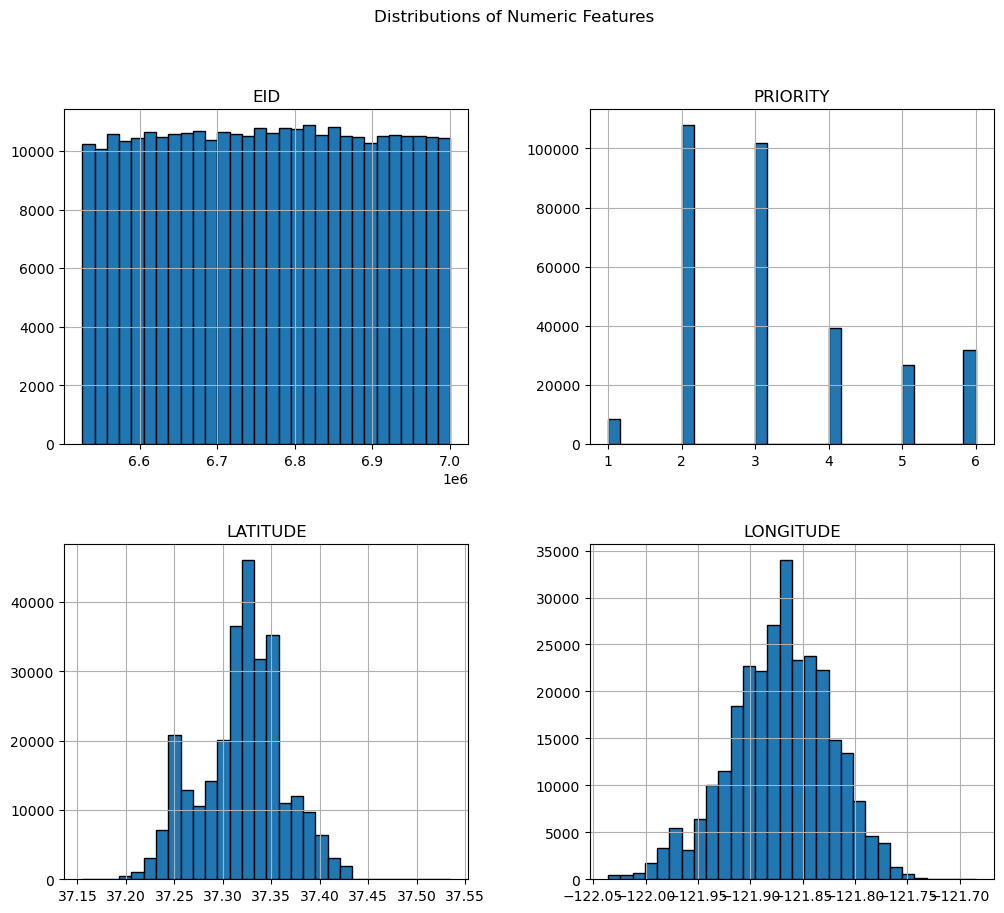

In [125]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [126]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE              47
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS             10502
CITY                    0
STATE                   0
LATITUDE            32066
LONGITUDE           32066
neighborhood        33517
dtype: int64

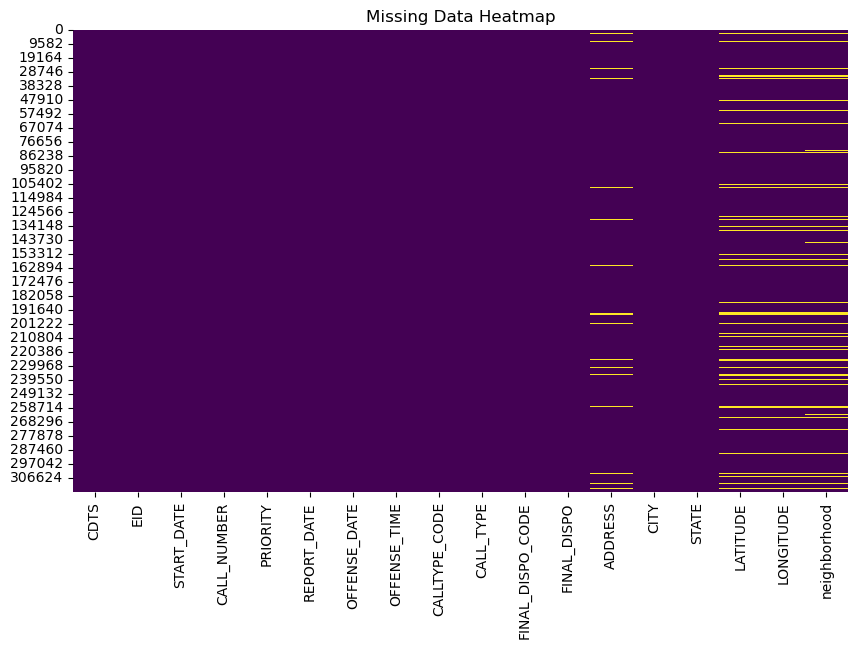

In [128]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [131]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 313958 unique values
START_DATE: 1 unique values
CALL_NUMBER: 306282 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 81206 unique values
CALLTYPE_CODE: 220 unique values
CALL_TYPE: 213 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 31333 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [132]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8435
Little Saigon and Spring Brook    5285
Five Wounds-San Jose High         4782
Trimble Business Area             4541
Fruitdale and Sherman Oaks        4346
                                  ... 
Villages                            56
Linda Vista and Hillcrest           45
Meadowlands                         44
Alta Vista                          26
Santa Teresa Hills                  18
Name: count, Length: 295, dtype: int64

In [133]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          125971
CAN         51475
R           37329
NR          22402
G           19294
E            8628
D            7956
GD           7046
A            6054
DUPNCAN      5778
O            4635
H            4323
T            3731
C            3554
B            2893
ADV          2299
U            1713
F             875
M             111
P              60
Z              40
TOT             7
Name: count, dtype: int64

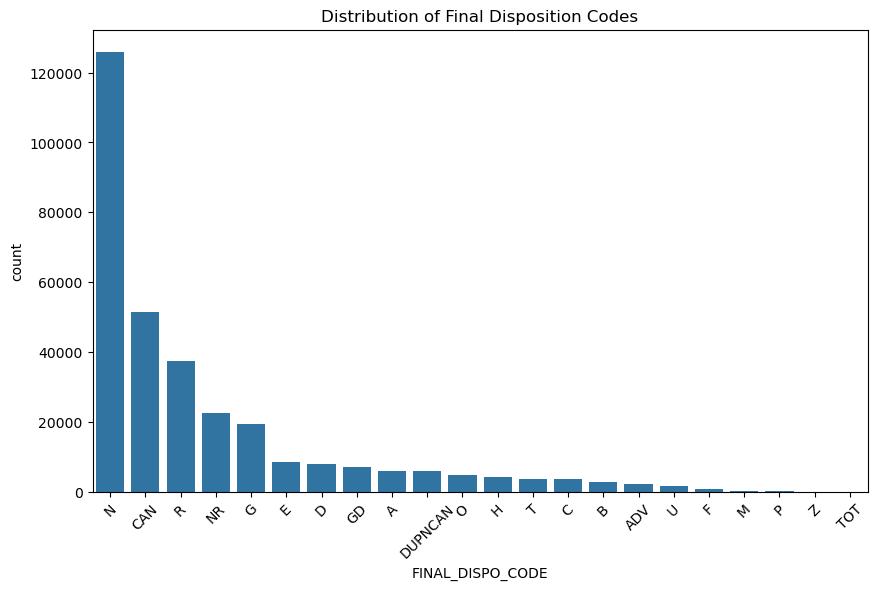

In [134]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [135]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    125971
Canceled                           51475
Report taken                       37329
No Response                        22402
Gone on Arrival/unable to loca     19294
No Disposition                     15170
Traffic Citation Issued, Non-H      8628
Traffic Citation Issued, Hazar      7956
Arrest Made                         6054
Supplemental report taken           4635
Courtesy Service/Citizen or ag      4323
Turned over To (TOT)                3731
Criminal Citation                   3554
Arrest by Warrant                   2893
Unfounded event                     1713
Field Interview (F.I.) Complet       875
Stranded motorist assist             111
Prior case, follow-up activity        60
Name: count, dtype: int64

In [136]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'CAN': 'Canceled',
 'N': 'No report required; dispatch r',
 'NR': 'No Response',
 'DUPNCAN': 'No Disposition',
 'GD': 'No Disposition',
 'G': 'Gone on Arrival/unable to loca',
 'T': 'Turned over To (TOT)',
 'H': 'Courtesy Service/Citizen or ag',
 'B': 'Arrest by Warrant',
 'R': 'Report taken',
 'U': 'Unfounded event',
 'A': 'Arrest Made',
 'O': 'Supplemental report taken',
 'E': 'Traffic Citation Issued, Non-H',
 'C': 'Criminal Citation',
 'D': 'Traffic Citation Issued, Hazar',
 'F': 'Field Interview (F.I.) Complet',
 'ADV': 'No Disposition',
 'M': 'Stranded motorist assist',
 'P': 'Prior case, follow-up activity',
 'Z': 'No Disposition',
 'TOT': 'No Disposition'}

In [137]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'1057': 'FIREARMS DISCHARGED',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '602PC': 'TRESPASSING',
 '1066': 'SUSPICIOUS PERSON',
 '415F': 'DISTURBANCE, FAMILY',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '22500': 'PARKING VIOLATION',
 '415': 'DISTURBANCE',
 '10851': 'STOLEN VEHICLE',
 'FNDPRP': 'FOUND PROPERTY',
 '415A': 'DISTURBANCE, FIGHT',
 '1033A': 'ALARM, AUDIBLE',
 '242': 'BATTERY',
 'WELCK': 'WELFARE CHECK',
 '23103': 'RECKLESS DRIVING',
 '415M': 'DISTURBANCE, MUSIC',
 'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 '1080': 'EXPLOSION',
 '1195': 'VEHICLE STOP',
 '1125': 'TRAFFIC HAZARD',
 '23110': 'THROWING SUBSTANCES AT VEHICLE',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '6M': 'MISDEMEANOR WANT',
 '422': 'CRIMINAL THREATS',
 '415WEMS': 'DISTURBANCE, WEAPON (COMBINED ',
 '1095': 'PEDESTRIAN STOP',
 '1066X': 'SUSPICIOUS FEMALE',
 '1053': 'PERSON DOWN',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '911CELL': 'UNK TYPE 911 CALL FROM CELL',
 '10851R': 'RECOVERED STOLEN VEHICLE',
 '1154': 'SUSPICIOUS VE

## Focus on Target Dispositions

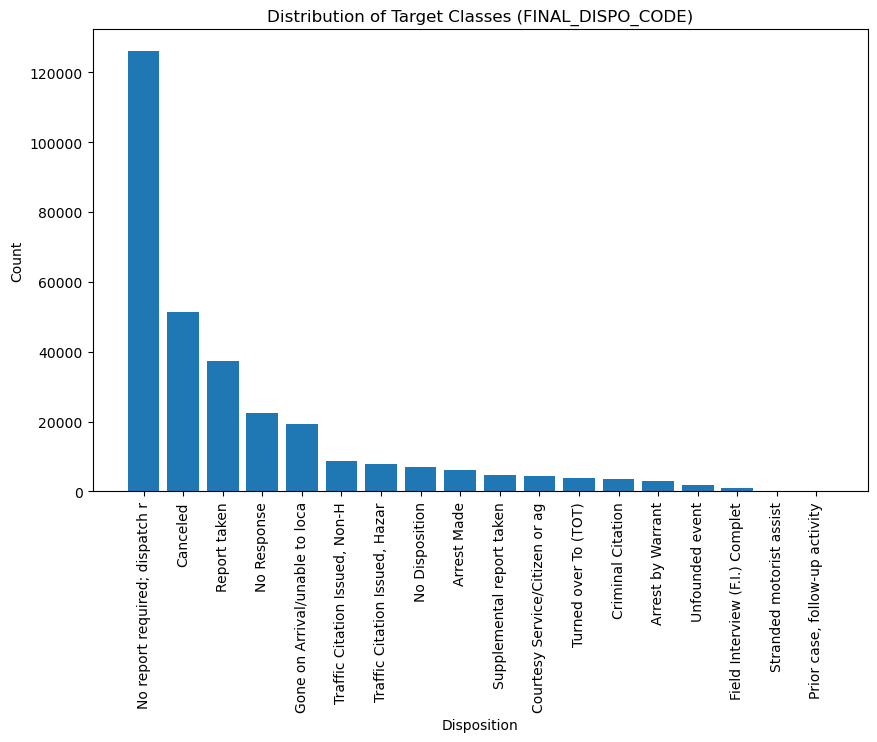

In [139]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [140]:
model_utils.transform_offense_date(all_police_df)

In [142]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    303673
A          6054
C          3554
B          2893
Name: count, dtype: int64

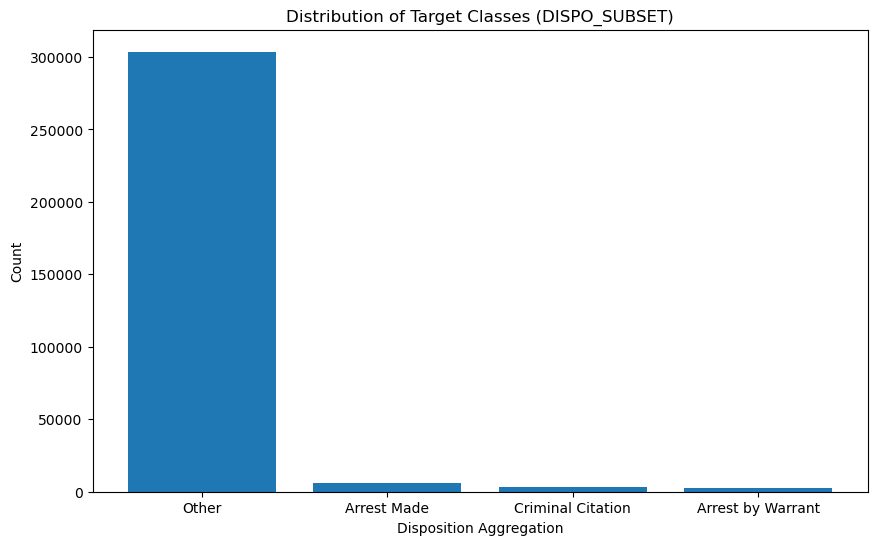

In [146]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.savefig('images/class_imbalance.png')
plt.show()

## Data Cleaning and Feature Engineering

In [154]:
police_calls_encoded = model_utils.clean_and_transform_data(all_police_df)

Police Calls Dataset: 316174 rows before cleaning, 282657 rows after cleaning.


In [156]:
police_calls_encoded.shape

(282657, 15)

In [158]:
police_calls_encoded

,PRIORITY,CALLTYPE_CODE,LATITUDE,LONGITUDE,neighborhood,OFFENSE_HOUR,OFFENSE_DAY_OF_WEEK,OFFENSE_MONTH,OFFENSE_YEAR,AFTER_COVID,DISPO_SUBSET,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2
0,2,1057,0.235569,-0.052830,South University,0,6,1,2017,No,Other,0.015426,0.055493,-0.012445,0.002791
1,1,1057,0.433946,-0.394729,St James Park,0,6,1,2017,No,Other,0.003290,0.188309,-0.171291,0.155811
2,4,415FC,-0.327369,1.818258,Cadwallader,0,6,1,2017,No,Other,0.107657,0.107170,-0.595241,3.306062
3,4,415FC,-0.714267,-0.147869,Canoas Garden and Almaden,0,6,1,2017,No,Other,0.049777,0.510178,0.105618,0.021865
5,4,415FC,0.670033,-1.054135,Airport,0,6,1,2017,No,Other,0.036398,0.448944,-0.706305,1.111200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316167,2,1053,0.414628,-0.020740,Naglee,0,6,12,2017,No,Other,0.014644,0.171916,-0.008599,0.000430
316168,3,484,2.407922,-1.997584,Alviso,0,6,12,2017,No,Other,0.117005,5.798090,-4.810027,3.990342
316170,3,1033A,-1.851798,-0.428789,Almaden Winery,0,6,12,2017,No,Other,0.098134,3.429156,0.794030,0.183860
316171,2,1057,-0.062072,0.270832,Spartan Keyes and Wool Creek,0,6,12,2017,No,Other,0.035453,0.003853,-0.016811,0.073350


## Define X and Y

In [163]:
# load the encoder file
encoder = joblib.load('one_hot_encoder.pkl')

In [165]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled, _ = \
    model_utils.split_data(police_calls_encoded, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(226125, 14)
(56532, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 217076, 0: 4397, 2: 2565, 1: 2087})
Counter({3: 9049, 0: 4397, 2: 2565, 1: 2087})


In [166]:
X_train.shape

(226125, 529)

In [167]:
X_train

,PRIORITY,LATITUDE,LONGITUDE,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2,CALLTYPE_CODE_1033,CALLTYPE_CODE_1033A,CALLTYPE_CODE_1033CTX,...,neighborhood_Willow Glen South,neighborhood_Willow Glen West,neighborhood_Willow Vale,neighborhood_Willowmont,neighborhood_Winchester,neighborhood_Winchester Lynnhaven,neighborhood_Windmill Springs,neighborhood_Wooster and East Ct and West Ct,neighborhood_YB Lucretia,AFTER_COVID_Yes
276243,1.354225,0.484084,1.310776,0.549869,-0.565137,0.736769,0.492934,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112219,1.354225,1.057688,0.497126,-0.333839,0.091348,0.633278,-0.519072,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168733,0.602279,1.668942,-1.038333,0.119744,1.326999,-1.475512,0.055083,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264054,0.602279,0.497265,-0.623158,-1.303084,-0.555519,-0.147422,-0.420465,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276738,-0.901614,-0.032441,-0.899901,-0.746453,-0.739513,0.168451,-0.129861,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83084,-0.901614,-1.226314,-0.743551,0.415952,0.368898,0.992370,-0.307005,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163848,2.106171,0.305386,1.333453,0.584771,-0.670148,0.525116,0.534200,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197869,2.106171,-0.070297,-0.488413,-1.069734,-0.736759,0.174127,-0.523776,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45046,-0.149668,-0.928153,-2.389790,1.602504,-0.105597,2.206127,3.247239,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


y_train distribution: Counter({3: 217076, 0: 4397, 2: 2565, 1: 2087})
y_test distribution: Counter({3: 54270, 0: 1099, 2: 641, 1: 522})
y_train_resampled distribution: Counter({3: 217076, 0: 4397, 2: 2565, 1: 2087})


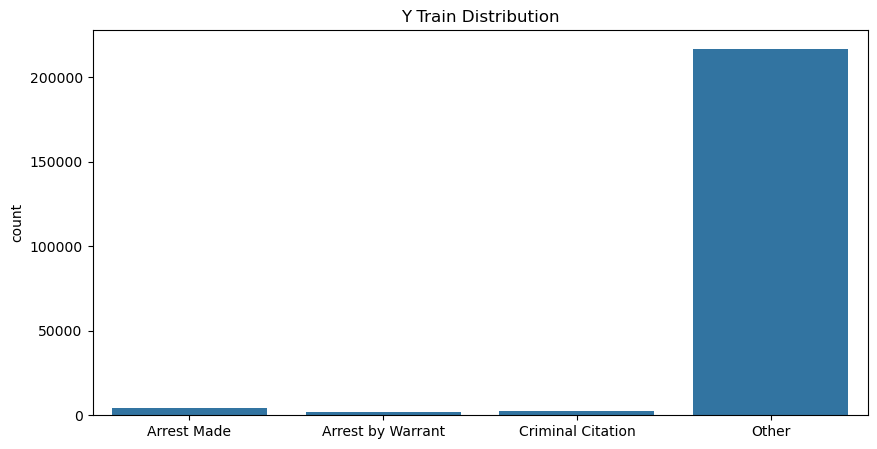

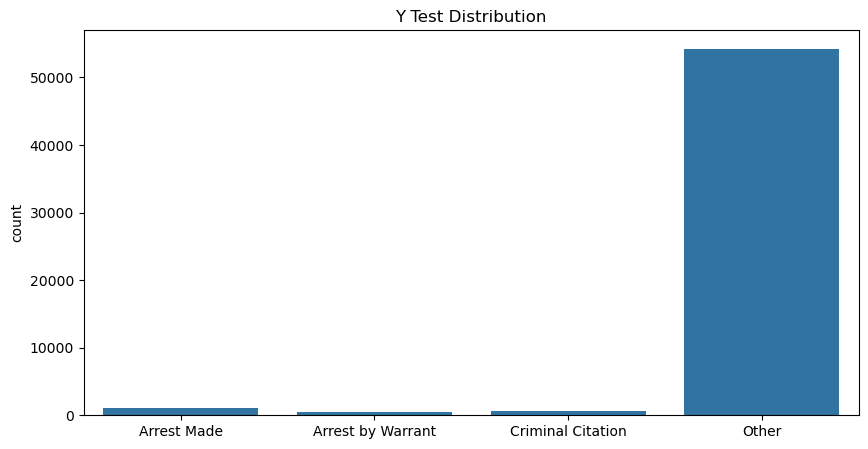

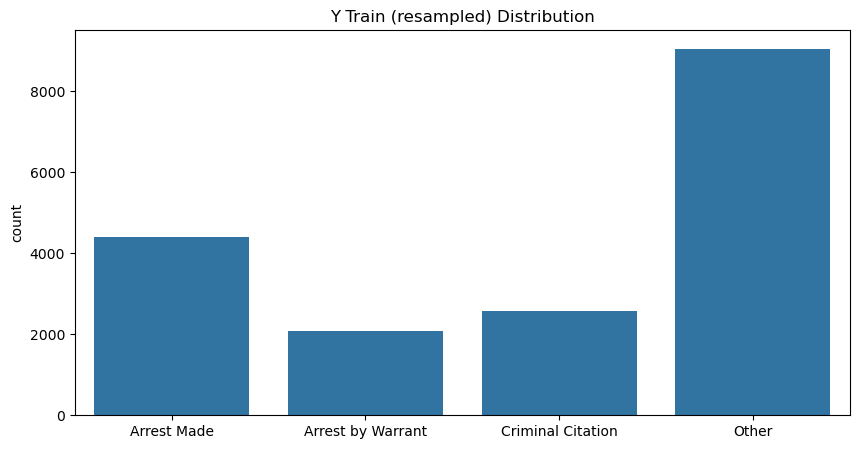

In [168]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [174]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [175]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [179]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00      1099
Arrest by Warrant       0.00      0.00      0.00       522
Criminal Citation       0.00      0.00      0.00       641
            Other       0.96      1.00      0.98     54270

         accuracy                           0.96     56532
        macro avg       0.24      0.25      0.24     56532
     weighted avg       0.92      0.96      0.94     56532



### Logistic Regression

In [182]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [183]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [184]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.17      0.65      0.27      1099
Arrest by Warrant       0.55      0.70      0.62       522
Criminal Citation       0.13      0.46      0.21       641
            Other       0.99      0.90      0.94     54270

         accuracy                           0.89     56532
        macro avg       0.46      0.68      0.51     56532
     weighted avg       0.96      0.89      0.92     56532



#### Hyperparameter Tuning

In [186]:
grid_search_scoring_method = 'f1_macro'

In [187]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=param_grid_lr, 
                              cv=5, n_jobs=2, verbose=1, scoring=grid_search_scoring_method)

grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=2, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [188]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10}
Best Score (f1_macro): 0.5885


In [189]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2017/best_logistic_regression.pkl']

In [190]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [191]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.55      0.29      0.38      1099
Arrest by Warrant       0.78      0.68      0.73       522
Criminal Citation       0.49      0.15      0.22       641
            Other       0.98      0.99      0.99     54270

         accuracy                           0.97     56532
        macro avg       0.70      0.53      0.58     56532
     weighted avg       0.96      0.97      0.96     56532



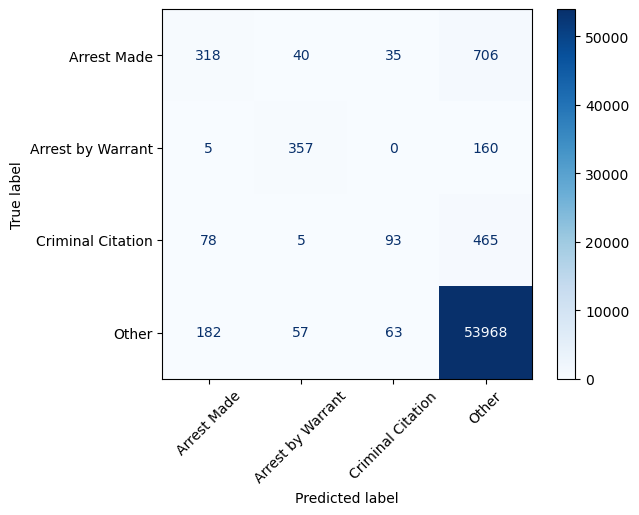

In [192]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [194]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [195]:
# Create a DataFrame to store the feature importance results
importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance_mean': permutation_importance_result.importances_mean
})

# Define a mapping of one-hot encoded columns to their original categorical feature
# This is a dictionary where keys are the original feature names, and values are lists of one-hot encoded columns
one_hot_mapping = {
    'CALLTYPE_CODE': [col for col in X_test_sample.columns if col.startswith("CALLTYPE_CODE_")],
    'neighborhood': [col for col in X_test_sample.columns if col.startswith("neighborhood_")]
}

# Initialize a list to store aggregated and non-one-hot encoded features
final_importance = []

# 1. Aggregate the importance for one-hot encoded features
for original_feature, encoded_columns in one_hot_mapping.items():
    # Sum the importance of the one-hot encoded columns for this feature
    aggregated_importance = importance_df.loc[importance_df['feature'].isin(encoded_columns), 'importance_mean'].sum()
    final_importance.append({
        'feature': original_feature,
        'importance_mean': aggregated_importance
    })

# 2. Add the importance of the non-one-hot encoded features
# Find columns that are not part of the one-hot encoded mappings
all_one_hot_encoded_columns = [col for sublist in one_hot_mapping.values() for col in sublist]
non_one_hot_encoded_features = importance_df.loc[~importance_df['feature'].isin(all_one_hot_encoded_columns)]

# Append non-one-hot encoded features' importance to the final list
for _, row in non_one_hot_encoded_features.iterrows():
    final_importance.append({
        'feature': row['feature'],
        'importance_mean': row['importance_mean']
    })

# Convert final importance list to a DataFrame
final_importance_df = pd.DataFrame(final_importance)

# Sort by importance for easier interpretation
final_importance_df = final_importance_df.sort_values(by='importance_mean', ascending=False)

In [200]:
# Use display to see the dataframe nicely formatted
from IPython.display import display
display(final_importance_df)

,feature,importance_mean
0,CALLTYPE_CODE,0.022112
3,LATITUDE,0.000531
8,LONGITUDE^2,0.000383
4,LONGITUDE,0.000206
6,LATITUDE^2,0.000177
2,PRIORITY,0.000147
9,AFTER_COVID_Yes,0.000000
7,LATITUDE LONGITUDE,-0.000029
5,DISTANCE_FROM_CENTER,-0.000147
1,neighborhood,-0.000383


In [201]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [202]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                           Feature  Importance  \
200                               CALLTYPE_CODE_6M    0.006958   
199                               CALLTYPE_CODE_6F    0.002801   
64                             CALLTYPE_CODE_11377    0.001769   
80                             CALLTYPE_CODE_12020    0.001238   
8                              CALLTYPE_CODE_1033A    0.001061   
84                             CALLTYPE_CODE_14601    0.000826   
136                              CALLTYPE_CODE_415    0.000531   
196                             CALLTYPE_CODE_647F    0.000531   
1                                         LATITUDE    0.000531   
184                             CALLTYPE_CODE_601T    0.000501   
67                             CALLTYPE_CODE_11550    0.000413   
59                             CALLTYPE_CODE_11300    0.000413   
6                                      LONGITUDE^2    0.000383   
217                           CALLTYPE_CODE_CODE6F    0.000354   
102       

In [203]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                  Display Name  Coefficient
184                   Call Type: TRUANT (TABS)     3.916258
107                 Call Type: MISDEMEANOR DUI     2.866584
76           Call Type: VEHICLE STOP ON FEMALE    -2.769269
87   Call Type: RESISTING ARREST, GANG RELATED     2.752362
196                 Call Type: DRUNK IN PUBLIC     2.527145
82      Call Type: CARRYING A CONCEALED WEAPON     2.380289
8                    Call Type: ALARM, AUDIBLE    -2.351546
102               Call Type: PARKING VIOLATION    -2.295621
67      Call Type: USE OF CONTROLLED SUBSTANCE     2.279899
72   Call Type: VEHICLE ACCIDENT, PROPERTY DAM    -2.261216
108                      Call Type: FELONY DUI     2.146283
86                 Call Type: RESISTING ARREST     2.081250
58                   Call Type: TRAFFIC HAZARD    -2.026823
113           Call Type: ASSAULT ON AN OFFICER     2.011619
225   Call Type: VIOLATION OF PROTECTIVE ORDER     1.999232
129    Call Type: R

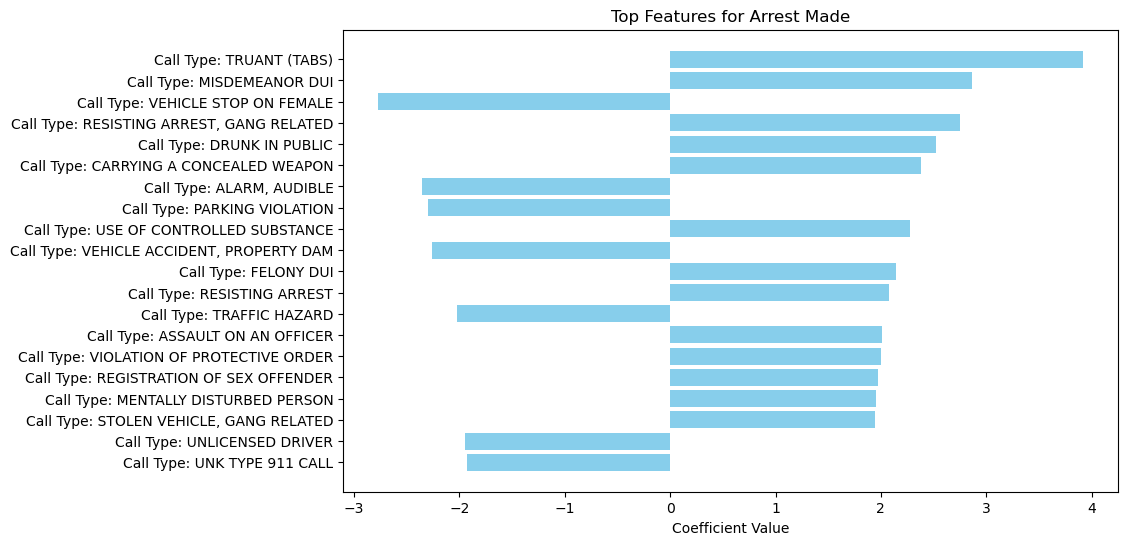

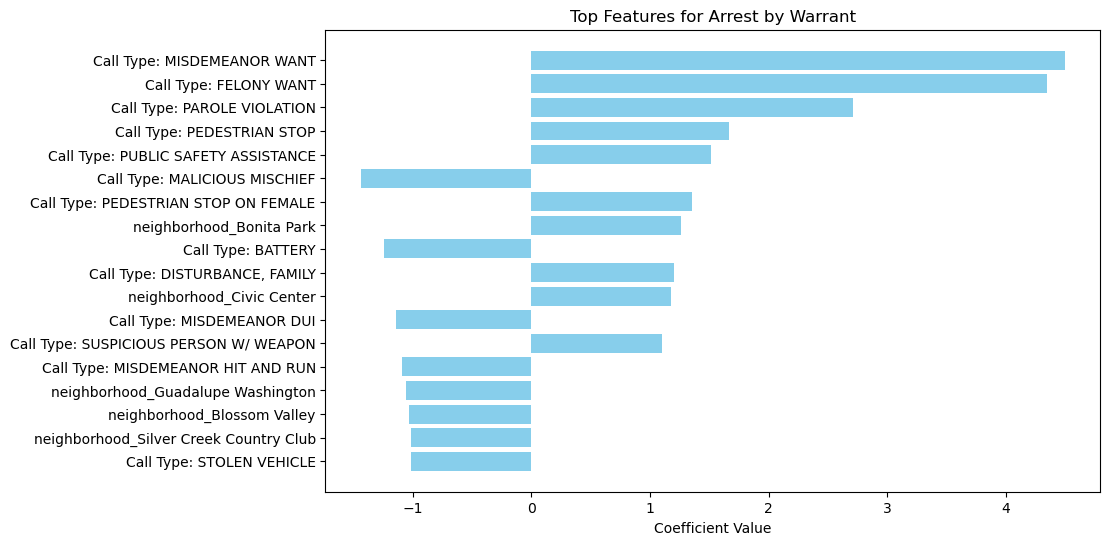

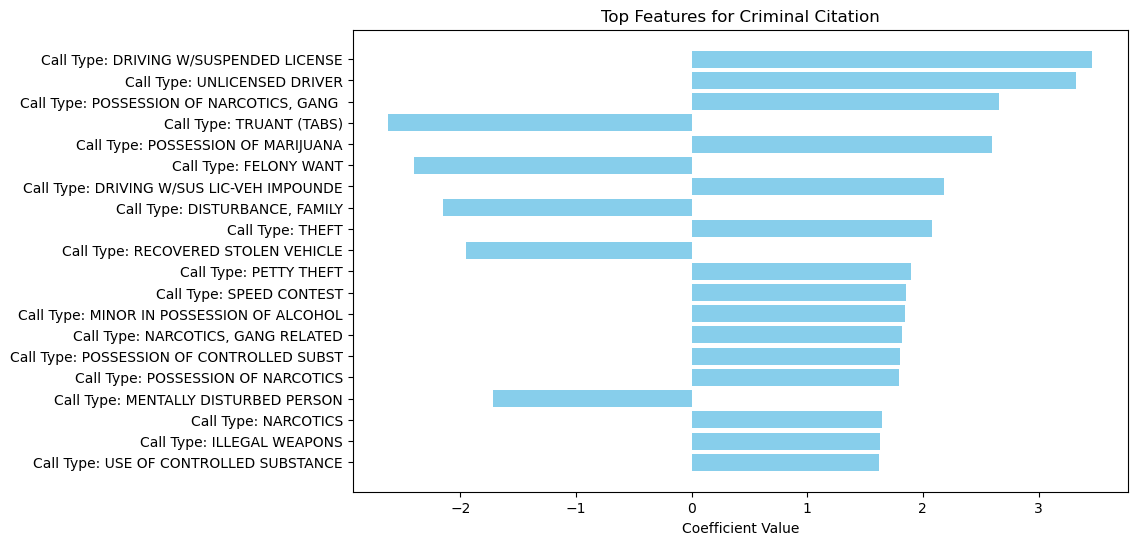

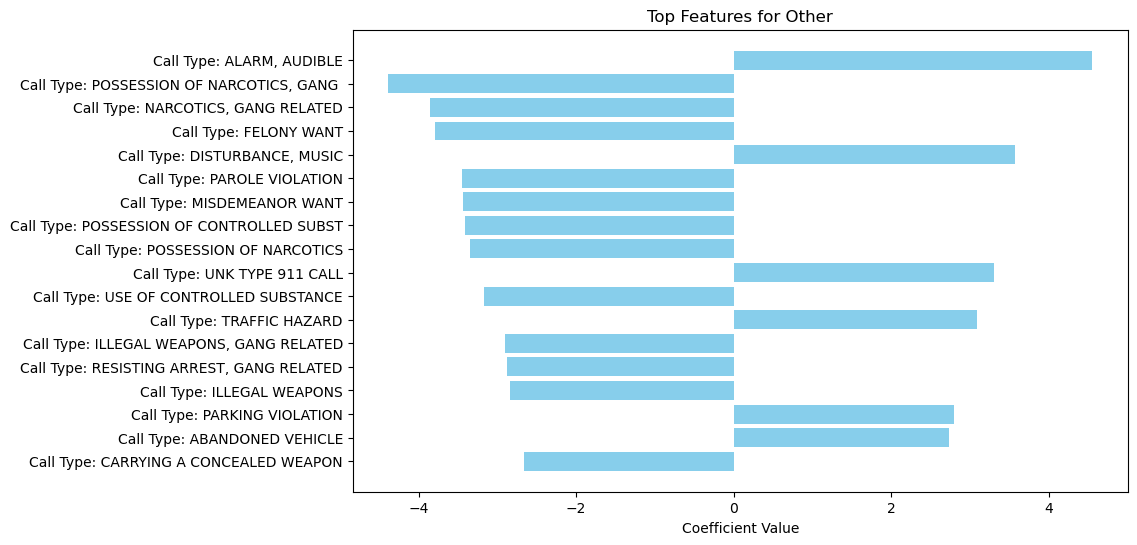

In [204]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [206]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [207]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.48      0.31      0.38      1099
Arrest by Warrant       0.71      0.61      0.66       522
Criminal Citation       0.38      0.20      0.27       641
            Other       0.98      0.99      0.98     54270

         accuracy                           0.96     56532
        macro avg       0.64      0.53      0.57     56532
     weighted avg       0.96      0.96      0.96     56532



#### Hyperparameter Tuning and Cross Validation

In [209]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=-1,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 60}
Best Score (f1_macro): 0.57


In [210]:
best_rf = grid_rf.best_estimator_

In [211]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2017/best_random_forest.pkl']

In [212]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [213]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.49      0.30      0.37      1099
Arrest by Warrant       0.71      0.60      0.65       522
Criminal Citation       0.38      0.20      0.26       641
            Other       0.98      0.99      0.98     54270

         accuracy                           0.96     56532
        macro avg       0.64      0.52      0.57     56532
     weighted avg       0.96      0.96      0.96     56532



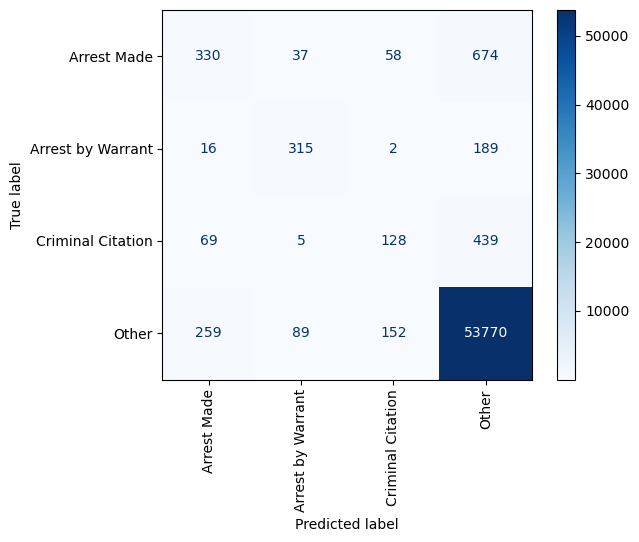

In [214]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

plt.show()

In [215]:
#### Optuna

def rf_objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize RandomForest with suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro').mean()
    return score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-10-08 15:17:11,528] A new study created in memory with name: no-name-a5fc2427-0dc9-4f52-a1a3-9eb0903ab6d7
[I 2024-10-08 15:17:12,953] Trial 0 finished with value: 0.6543813117255498 and parameters: {'n_estimators': 81, 'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6543813117255498.
[I 2024-10-08 15:17:14,526] Trial 1 finished with value: 0.6814217945376544 and parameters: {'n_estimators': 95, 'max_depth': 85, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6814217945376544.
[I 2024-10-08 15:17:15,598] Trial 2 finished with value: 0.667397285105267 and parameters: {'n_estimators': 58, 'max_depth': 69, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6814217945376544.
[I 2024-10-08 15:17:16,610] Trial 3 finished with value: 0.31262778263348223 and parameters: {'n_estimators': 79, 'max_depth': 16, 'min

Best hyperparameters: {'n_estimators': 62, 'max_depth': 68, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [216]:
best_params = study.best_params
best_params

{'n_estimators': 62,
 'max_depth': 68,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt'}

In [217]:
# Train the RandomForest using the best hyperparameters
best_rf_2 = RandomForestClassifier(**best_params, n_jobs=-1)
best_rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=68, min_samples_split=10, n_estimators=62,
                       n_jobs=-1)

In [218]:
# Use the best estimator to make predictions
y_pred_best_rf_2 = best_rf_2.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf_2, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.57      0.28      0.37      1099
Arrest by Warrant       0.78      0.66      0.71       522
Criminal Citation       0.47      0.16      0.24       641
            Other       0.98      0.99      0.99     54270

         accuracy                           0.97     56532
        macro avg       0.70      0.52      0.58     56532
     weighted avg       0.96      0.97      0.96     56532



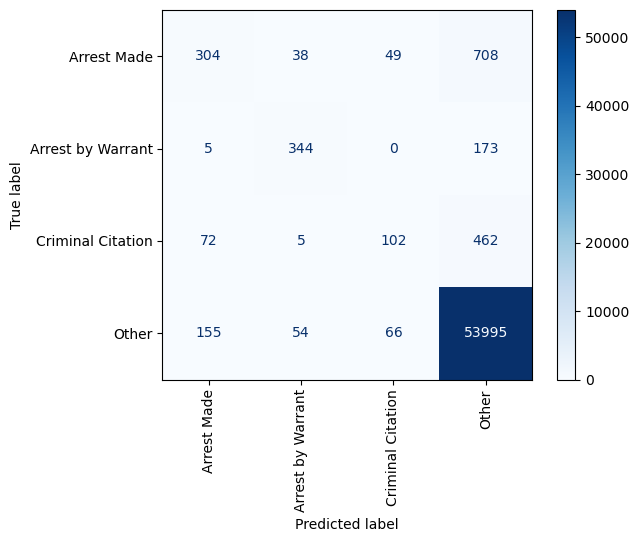

In [219]:
ConfusionMatrixDisplay.from_estimator(best_rf_2, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

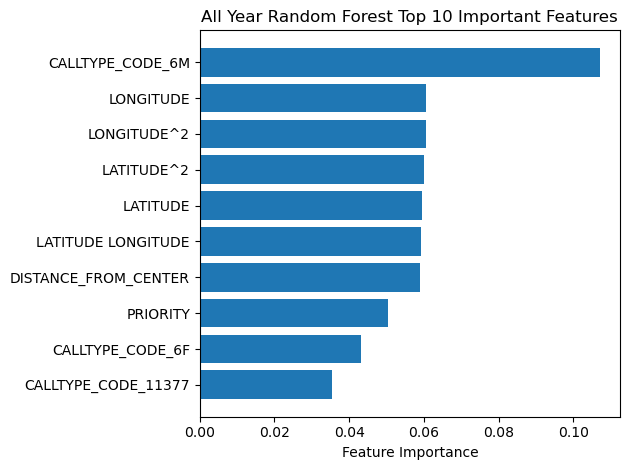

In [221]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('All Year Random Forest Top 10 Important Features')
plt.tight_layout()  # Adjusts the padding automatically
plt.savefig('images/all_year_random_forest_feature_importance.png')
plt.show()

In [340]:
print(call_type_code_mapping['6M'])
print(call_type_code_mapping['6F']) 
print(call_type_code_mapping['601T'])
print(call_type_code_mapping['11377'])

MISDEMEANOR WANT
FELONY WANT
TRUANT (TABS)
POSSESSION OF NARCOTICS


### Multilayer Perceptron Model

In [223]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [224]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [225]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9589 - loss: 0.1807 - val_accuracy: 0.9694 - val_loss: 0.1174
Epoch 2/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9688 - loss: 0.1191 - val_accuracy: 0.9692 - val_loss: 0.1155
Epoch 3/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9688 - loss: 0.1154 - val_accuracy: 0.9691 - val_loss: 0.1173
Epoch 4/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9699 - loss: 0.1121 - val_accuracy: 0.9688 - val_loss: 0.1168
Epoch 5/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9705 - loss: 0.1084 - val_accuracy: 0.9694 - val_loss: 0.1179


In [226]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2017/mlp_model.pkl']

In [227]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [228]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1767/1767 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - accuracy: 0.9683 - loss: 0.1162
Test Accuracy: 0.9684


In [229]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1767/1767 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.58      0.25      0.35      1099
Arrest by Warrant       0.77      0.69      0.73       522
Criminal Citation       0.45      0.21      0.28       641
            Other       0.98      0.99      0.99     54270

         accuracy                           0.97     56532
        macro avg       0.69      0.53      0.59     56532
     weighted avg       0.96      0.97      0.96     56532



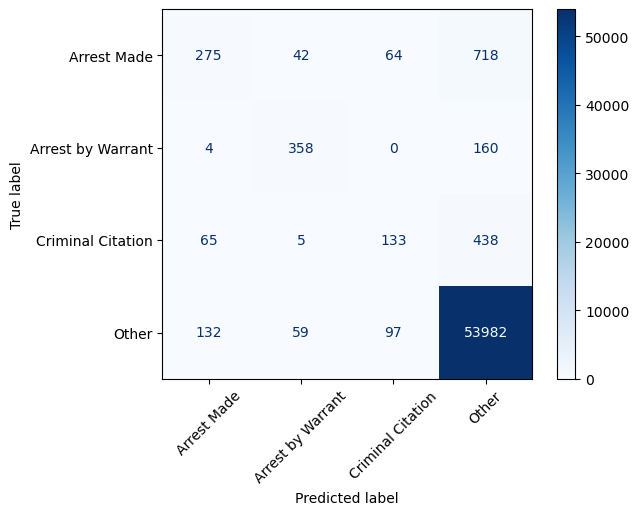

In [230]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [233]:
def objective(trial):
    params = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-08 15:18:30,050] A new study created in memory with name: no-name-83f4a29a-76ed-44d1-bc12-56f50743dfd2
[I 2024-10-08 15:18:59,567] Trial 0 finished with value: 0.6592897312335421 and parameters: {'learning_rate': 0.002380831779215697, 'max_depth': 9, 'subsample': 0.8783473601996992, 'colsample_bytree': 0.6317085817229483, 'gamma': 0.0002769836518712471, 'reg_alpha': 1.61775341498636e-08, 'reg_lambda': 0.018078298066732484}. Best is trial 0 with value: 0.6592897312335421.
[I 2024-10-08 15:19:32,717] Trial 1 finished with value: 0.7008819835253075 and parameters: {'learning_rate': 0.06575865446824541, 'max_depth': 12, 'subsample': 0.6960412900093669, 'colsample_bytree': 0.7341446464937889, 'gamma': 3.152628803400012e-08, 'reg_alpha': 0.00011974992892028669, 'reg_lambda': 6.831074831506512e-07}. Best is trial 1 with value: 0.7008819835253075.
[I 2024-10-08 15:20:02,524] Trial 2 finished with value: 0.6560836541387486 and parameters: {'learning_rate': 0.0011827161418262618, 'max

Actual runtime: 463.36 seconds (7.72 minutes)
Best parameters found:  {'learning_rate': 0.26243420598161366, 'max_depth': 3, 'subsample': 0.9629771758069586, 'colsample_bytree': 0.9161384558579198, 'gamma': 2.1770053341709922e-07, 'reg_alpha': 0.34474472014124646, 'reg_lambda': 1.126972167579451e-05}
Best F1 macro score:  0.7034138897736372


In [234]:
# train the final model with the best parameters:
best_params = study.best_params
xgb_1_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_1_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9161384558579198, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=2.1770053341709922e-07, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.26243420598161366, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [235]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2017/xgb_model.pkl']

In [236]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [237]:
y_pred_best_xgb = best_xg.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.25      0.35      1099
Arrest by Warrant       0.78      0.68      0.73       522
Criminal Citation       0.49      0.15      0.23       641
            Other       0.98      1.00      0.99     54270

         accuracy                           0.97     56532
        macro avg       0.70      0.52      0.57     56532
     weighted avg       0.96      0.97      0.96     56532



## Ensemble

In [239]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [240]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.578650968032222
RF F1: 0.5668886685653357
XGB F1: 0.574249334159054


In [241]:
best_lr

LogisticRegression(C=10, max_iter=1000, random_state=42)

In [242]:
best_rf

RandomForestClassifier(n_estimators=60)

In [243]:
best_xg

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9161384558579198, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=2.1770053341709922e-07, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.26243420598161366, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [244]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

base_estimators_fitted = [best_lr, best_rf, best_xg]

In [245]:
X_train_float = X_train.astype('float64')

In [246]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=2)
stacking_clf_2.fit(X_train_float, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9161384558579198,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              e...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=2)

In [247]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2017/stacking_2.pkl']

In [248]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [249]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.6030628560933124


In [250]:
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking_2, zero_division=0, target_names=label_names))

Ensemble Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.34      0.43      1099
Arrest by Warrant       0.78      0.68      0.73       522
Criminal Citation       0.48      0.19      0.27       641
            Other       0.98      0.99      0.99     54270

         accuracy                           0.97     56532
        macro avg       0.70      0.55      0.60     56532
     weighted avg       0.96      0.97      0.96     56532



## Results

In [252]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Ensemble'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.959987,0.250000,0.239997,0.244896
Logistic Regression,0.968230,0.528196,0.696519,0.578651
Random Forest,0.964816,0.523549,0.637180,0.566889
MLP,0.968443,0.534558,0.694466,0.586306
XGB,0.968337,0.521458,0.701307,0.574249
Ensemble,0.968991,0.552497,0.700624,0.603063


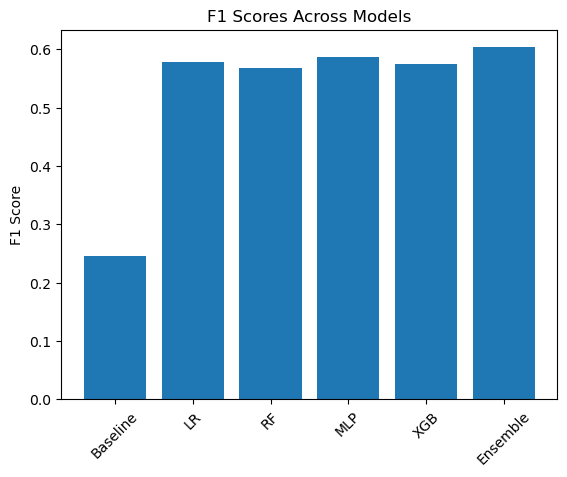

In [253]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Ensemble']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Comparison with the All-Year Models

In [255]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [256]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

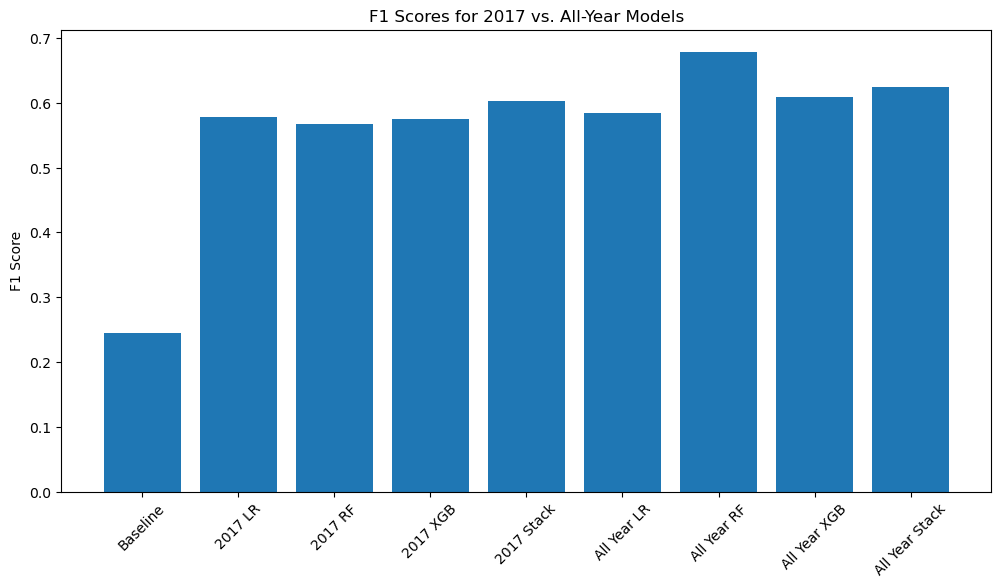

In [257]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()

## 2017 vs. Non-2017 Models

In [259]:
other_years = [y for y in range(2013, 2025) if str(y) != year]
other_years

[2013, 2014, 2015, 2016, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

In [260]:
other_years_df = model_utils.load_data(other_years)
model_utils.transform_offense_date(other_years_df)
dispo_mapping = model_utils.calc_dispo_subset(other_years_df)
all_police_df.shape

(316174, 24)

In [261]:
other_years_clean = model_utils.clean_and_transform_data(other_years_df)
other_years_clean.shape

Police Calls Dataset: 3270683 rows before cleaning, 2918305 rows after cleaning.


(2918305, 15)

In [262]:
X_train_oy, X_test_oy, y_train_oy, y_test_oy, _, _, X_train_resampled_oy, y_train_resampled_oy, _ = \
    model_utils.split_data(other_years_clean, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(2334644, 14)
(583661, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Counter({3: 2240129, 0: 48204, 2: 26125, 1: 20186})
Counter({3: 94515, 0: 48204, 2: 26125, 1: 20186})


In [263]:
rf_model_oy = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model_oy.fit(X_train_oy, y_train_oy)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [264]:
y_pred_rf_oy = rf_model_oy.predict(X_test_oy)

print(f"Random Forest Other Years Classification Report for Non-{year} Data:")
print(classification_report(y_test_oy, y_pred_rf_oy, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for Non-2017 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.37      0.45     12051
Arrest by Warrant       0.67      0.52      0.59      5047
Criminal Citation       0.46      0.22      0.30      6531
            Other       0.98      0.99      0.98    560032

         accuracy                           0.97    583661
        macro avg       0.67      0.53      0.58    583661
     weighted avg       0.96      0.97      0.96    583661



In [265]:
y_pred_rf_oy_2017 = rf_model_oy.predict(X_test)

print(f"Random Forest Other Years Classification Report for {year} Data:")
print(classification_report(y_test, y_pred_rf_oy_2017, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for 2017 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.55      0.33      0.41      1099
Arrest by Warrant       0.78      0.64      0.71       522
Criminal Citation       0.45      0.18      0.26       641
            Other       0.98      0.99      0.98     54270

         accuracy                           0.97     56532
        macro avg       0.69      0.54      0.59     56532
     weighted avg       0.96      0.97      0.96     56532



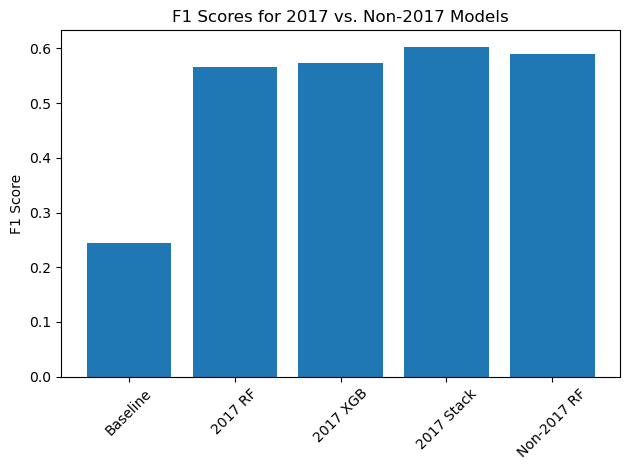

In [336]:
model_names = ['Baseline', f'{year} RF', f'{year} XGB', f'{year} Stack', f'Non-{year} RF']
f1_scores = [baseline_f1, rf_f1, xgb_1_f1, stack_2_f1, f1_score(y_test, y_pred_rf_oy_2017, average='macro')]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. Non-{year} Models')
plt.tight_layout()
plt.savefig(f'images/{year}_vs_non_year.png')
plt.show()